# Notebook layout

Note the user can activate 'Run All', however, some parts of the code have been commented out due to the requirement of all the supplied data for the particular code - which is confidential in nature and cannot be uploaded to a shared drive. The processed data, that retains confidentiality, has been loaded into the code at various stages to allow notebook functionality.

The notebook contains the following sections that refer to the Modelling report layout for Group 13:
- 1.4 Unsupervised Methods
    - 1.4.1 Gaussian Mixture Modelling
- 1.5 Supervised Methods
    - 1.5.1 Support Vector Machine
    - 1.5.2 XGBoost
- 1.6 PCS Check
    - 1.6.1 Model Stability
    - 1.6.3 Model Evaluation

In [1]:
#Setting the paths to save figures and models
import os
os.path.abspath(os.curdir)
os.chdir("..")
REPO_PATH = os.path.abspath(os.curdir)
FIGURE_PATH = REPO_PATH + '/reports/figures/'
print(FIGURE_PATH)

MODEL_PATH = REPO_PATH + '/models/'
print(MODEL_PATH)

/Users/connormcdonald/Desktop/Masters/MIT808/mit808-2022-project-significant-outliers-1/reports/figures/
/Users/connormcdonald/Desktop/Masters/MIT808/mit808-2022-project-significant-outliers-1/models/


### Importing Libraries

In [2]:
#General Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from functions import *

#Model Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, silhouette_score
import pickle

### 1.4 Unsupervised Methods

In [3]:
#Reading data in
df = read_from_drive('https://drive.google.com/file/d/1XE0ta9-okF0_MRJ5ft1_T0IrVMxf44Xx/view?usp=sharing')
df['lepto_bin'] = pd.Series(np.where(df.Lepto_Y_N.values == 'Yes', 1, 0),df.index)
df.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfall,temperature_max,temperature_min,temperature_diff,lepto_bin
0,0,1,1,2017,Yes,72.0,33.291304,-2.226002,-1.785191,-0.440811,1
1,1,2,1,2017,Yes,92.0,62.415942,-0.652248,-1.754252,1.102004,1
2,2,3,1,2017,Yes,98.0,-48.133333,-0.563832,-2.227761,1.663930,1
3,3,4,1,2017,Yes,100.0,-16.333333,-0.563832,-2.227761,1.663930,1
4,4,5,1,2017,Yes,100.0,28.066667,0.584506,-2.092082,2.676588,1


In [4]:
#Standardizing variables
df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']]= StandardScaler().fit_transform(df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']])

In [5]:
#Creating Subsets
X = df.iloc[:, [2,6,7,8,9]].values
X1 = df.iloc[:, [1,2,6,7,8,9,10]].values
Y = df.iloc[:, [10]].values

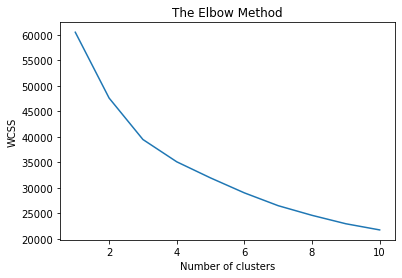

In [6]:
#finding optimal number of cluster with Kmeans and elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [7]:
#Training Gaussian Mixture Model

y_GMM = GaussianMixture(n_components=4, random_state=0).fit_predict(X)

score = silhouette_score(X,y_GMM, metric='euclidean')
print(f"silhouette score: {score}")

silhouette score: 0.019657575999972365


In [8]:
#Creating new column with Gaussian Clusters
df['gcluster'] = y_GMM
df.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfall,temperature_max,temperature_min,temperature_diff,lepto_bin,gcluster
0,0,1,-1.696335,2017,Yes,72.0,0.384001,-0.638384,-0.476291,-0.113954,1,3
1,1,2,-1.696335,2017,Yes,92.0,0.973356,0.099233,-0.462887,0.600546,1,3
2,2,3,-1.696335,2017,Yes,98.0,-1.263674,0.140674,-0.668036,0.860782,1,3
3,3,4,-1.696335,2017,Yes,100.0,-0.620182,0.140674,-0.668036,0.860782,1,3
4,4,5,-1.696335,2017,Yes,100.0,0.278278,0.678900,-0.609252,1.329758,1,3


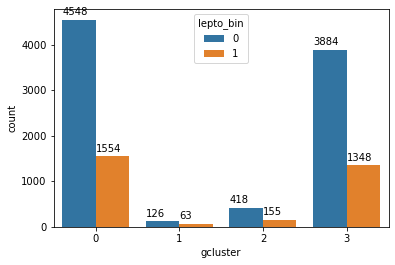

In [9]:
#Plotting pest presence per cluster

ax = sns.countplot(data=df,x='gcluster',hue='lepto_bin',)
for p in ax.patches:
   ax.annotate(f'{p.get_height()}', (p.get_x(), p.get_height()+100))

### Principle Component Analysis
- Note: this was done to see if the clustering would be improved. The results were not any better, therefore it was ignored in the report

In [10]:
#reading in data
df = read_from_drive('https://drive.google.com/file/d/1XE0ta9-okF0_MRJ5ft1_T0IrVMxf44Xx/view?usp=sharing')
df['lepto_bin'] = pd.Series(np.where(df.Lepto_Y_N.values == 'Yes', 1, 0),df.index)

df.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfall,temperature_max,temperature_min,temperature_diff,lepto_bin
0,0,1,1,2017,Yes,72.0,33.291304,-2.226002,-1.785191,-0.440811,1
1,1,2,1,2017,Yes,92.0,62.415942,-0.652248,-1.754252,1.102004,1
2,2,3,1,2017,Yes,98.0,-48.133333,-0.563832,-2.227761,1.663930,1
3,3,4,1,2017,Yes,100.0,-16.333333,-0.563832,-2.227761,1.663930,1
4,4,5,1,2017,Yes,100.0,28.066667,0.584506,-2.092082,2.676588,1


In [11]:
#Standardizing data
df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']]= StandardScaler().fit_transform(df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']])

In [12]:
# Separating out the features
x = df.iloc[:, [2,6,7,8,9]].values

# Separating out the target
y = df.iloc[:, [10]].values


In [13]:
#Performing PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pDf = pd.DataFrame(data = principalComponents,columns = ['pc1', 'pc2'])

In [14]:
#Adding target column to result dataframe

pDf['lepto'] = y
pDf.head()

,pc1,pc2,lepto
0,0.874616,0.954040,1
1,0.994715,0.200194,1
2,1.761981,-0.584492,1
3,1.622240,-0.391914,1
4,1.544481,-0.786815,1


In [15]:
#Creating Subsets
X = pDf.iloc[:, [0,1]].values
X1 = pDf.iloc[:, [0,1,2]].values
Y = pDf.iloc[:, [2]].values

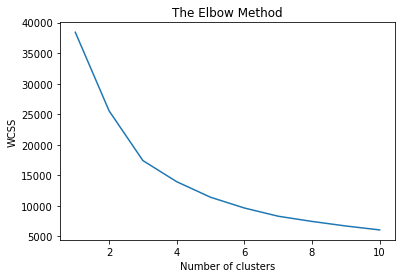

In [16]:
#Finding optimal number of clusters for Gaussian mixture model

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
#Creating Gaussian mixture model with PCA

GMM = GaussianMixture(n_components=3, random_state=42)

y_GMM = GMM.fit_predict(X)

# score = silhouette_score(X,y_GMM, metric='euclidean')
# print(f"silhouette score: {score}")
pDf['gcluster'] = y_GMM

Text(0.5, 1.0, 'Gaussian Clustering w/ PCA')

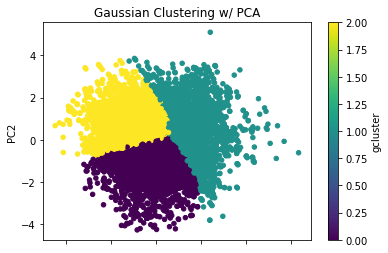

In [18]:
#Plotting clusters

pDf.plot(kind='scatter', x='pc1', y='pc2', c='gcluster', cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Gaussian Clustering w/ PCA')

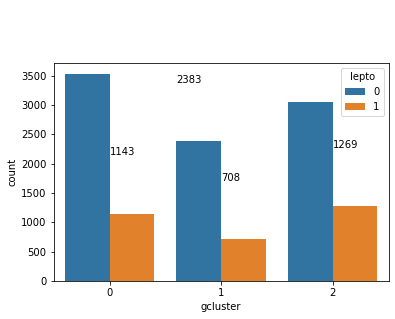

In [19]:
#Plotting pest presence per cluster

ax = sns.countplot(data=pDf,x='gcluster',hue='lepto')
for p in ax.patches:
   ax.annotate(f'{p.get_height()}', (p.get_x(), p.get_height()+1000))

### 1.5 Supervised Methods

In [20]:
#Reading in data
df = read_from_drive('https://drive.google.com/file/d/1XE0ta9-okF0_MRJ5ft1_T0IrVMxf44Xx/view?usp=sharing')
df['lepto_bin'] = pd.Series(np.where(df.Lepto_Y_N.values == 'Yes', 1, 0),df.index)
df.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfall,temperature_max,temperature_min,temperature_diff,lepto_bin
0,0,1,1,2017,Yes,72.0,33.291304,-2.226002,-1.785191,-0.440811,1
1,1,2,1,2017,Yes,92.0,62.415942,-0.652248,-1.754252,1.102004,1
2,2,3,1,2017,Yes,98.0,-48.133333,-0.563832,-2.227761,1.663930,1
3,3,4,1,2017,Yes,100.0,-16.333333,-0.563832,-2.227761,1.663930,1
4,4,5,1,2017,Yes,100.0,28.066667,0.584506,-2.092082,2.676588,1


In [21]:
#standardizing data
df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']]= StandardScaler().fit_transform(df[['Timeframe', 'rainfall', 'temperature_max', 'temperature_min', 'temperature_diff']])
# df = df[df.Year == 2016]
df.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfall,temperature_max,temperature_min,temperature_diff,lepto_bin
0,0,1,-1.696335,2017,Yes,72.0,0.384001,-0.638384,-0.476291,-0.113954,1
1,1,2,-1.696335,2017,Yes,92.0,0.973356,0.099233,-0.462887,0.600546,1
2,2,3,-1.696335,2017,Yes,98.0,-1.263674,0.140674,-0.668036,0.860782,1
3,3,4,-1.696335,2017,Yes,100.0,-0.620182,0.140674,-0.668036,0.860782,1
4,4,5,-1.696335,2017,Yes,100.0,0.278278,0.678900,-0.609252,1.329758,1


In [22]:
#Creating subsets

X = df.iloc[:, [2,6,7,8,9]]
X1 = df.iloc[:, [2,6,7,8,9,10]]
Y = df.iloc[:, 10]

# X = pDf.iloc[:, [0,1]].values
# X1 = pDf.iloc[:, [0,1,2]].values
# Y = pDf.iloc[:, [2]].values

In [23]:
#splitting into training and test set

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
scale_pos_weight = float(len(Y)/sum(Y))

In [24]:
#Training models

# svm = SVC(class_weight ='balanced', C=1, gamma='scale')
# xg = XGBClassifier(verbosity = 0, scale_pos_weight=scale_pos_weight)

# svm.fit(x_train, y_train)
# xg.fit(x_train, y_train)

#Loading models

svm = pickle.load(open(f'{MODEL_PATH}lepto_svm1.pickle', 'rb'))
xg = pickle.load(open(f'{MODEL_PATH}lepto_xgb1.pickle', 'rb'))

In [25]:
#Save models

# file = open(f'{MODEL_PATH}lepto_svm1.pickle','wb')
# pickle.dump(svm, file)
# file.close()

# file = open(f'{MODEL_PATH}lepto_xgb1.pickle','wb')
# pickle.dump(xg, file)
# file.close()

### 1.6.1 Model Stability

In [26]:
# saccuracies = cross_val_score(estimator = svm, X = x_train, y = y_train, cv = 3)
# print("SVM Cross-Validated Accuracy: {:.2f} %".format(saccuracies.mean()*100))
# print("SVM Cross-Validated Standard Deviation: {:.2f} %".format(saccuracies.std()*100))

# xaccuracies = cross_val_score(estimator = xg, X = x_train, y = y_train, cv = 3)
# print("XGBoost Cross-Validated Accuracy: {:.2f} %".format(xaccuracies.mean()*100))
# print("XGBoost Cross-Validated Standard Deviation: {:.2f} %".format(xaccuracies.std()*100))

### 1.6.3 Model Evaluation

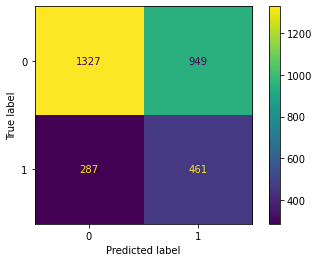

In [27]:
plot_confusion_matrix(svm, x_test, y_test)  
plt.show()

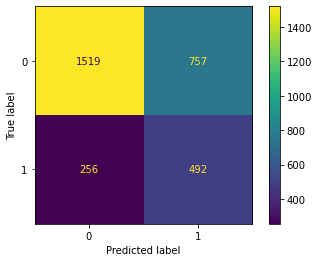

In [28]:
plot_confusion_matrix(xg, x_test, y_test)  
plt.show()

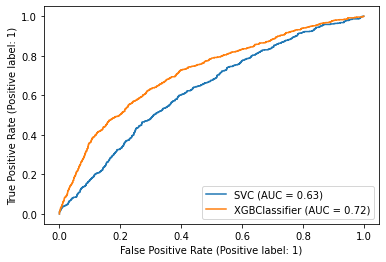

In [29]:
svm_roc = plot_roc_curve(svm, x_test, y_test)
xg_roc = plot_roc_curve(xg, x_test, y_test, ax=svm_roc.ax_)

### Hyperparameter Optimisation

In [30]:
#SVM Parameter Tuning

# parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
#               {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
# grid_search = GridSearchCV(estimator = svm,
#                            param_grid = parameters,
#                            scoring = 'roc_auc',
#                            cv = 10,
#                            n_jobs = -1)
# grid_search.fit(x_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)

In [34]:
#XGBoost Parameter Tuning

# parameters = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#               'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
#               'max_depth': [5,6,7,8,9,10,11,12,13,14],
#               'n_estimators': [50,65,80,100,115,130,150],
#               'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#               'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}


# grid_search = GridSearchCV(estimator = xg,
#                            param_grid = parameters,
#                            scoring = 'roc_auc',
#                            cv = 10,
#                            n_jobs = -1)
# grid_search.fit(x_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)